In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import os
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm import tqdm

In [6]:
#read all images with PIL and store in an array
data = []
for dirname, _, filenames in (os.walk('.')):
    for filename in sorted(filenames):
        if (filename.endswith('.jpg')):
            #print (os.path.join(dirname, filename))
            img = PIL.Image.open(os.path.join(dirname, filename))
            data.append(np.asarray(img).astype('float32'))
data = np.array(data, dtype='object')

In [9]:
max_x = 0
max_y = 0
for i in data:
    if (i.shape[0] > max_x):
        max_x = i.shape[0]
    if (i.shape[1] > max_y):
        max_y = i.shape[1]
print (max_x, max_y)

202 223


In [10]:
def pad_images(images, target_shape):
    padded_images = np.zeros((len(images),) + target_shape, dtype=np.uint8)

    for i, image in enumerate(images):
        pad_width = [(0, target_shape[0] - image.shape[0]),  # Rows padding
                     (0, target_shape[1] - image.shape[1]),  # Columns padding
                     (0, 0)]                                 # Channel padding

        padded_image = np.pad(image, pad_width, mode='constant')
        padded_images[i] = padded_image

    return padded_images


In [11]:
padded_data = pad_images(data, (256, 256, 3))

In [6]:
#transpose data from (2048, 256, 256, 3) to (2048, 3, 256, 256)
data_t = np.transpose(padded_data, (0, 3, 1, 2))

In [7]:
X = data_t.copy()/255
y = pd.read_csv('data.csv')['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [9]:
class Discrminator(torch.nn.Module):
    def __init__(self):
        super(Discrminator, self).__init__()
        self.convs = torch.nn.Sequential(
            nn.Conv2d(3, 1, kernel_size=(8,8), stride=8),
            nn.ReLU(),
            nn.Conv2d(1, 1, kernel_size=(8,8), stride=8),
            nn.ReLU(),
            nn.Flatten(),
            nn.LazyLinear(10),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.LazyLinear(1),
            nn.Sigmoid()
            
        )

    def forward(self, x):
        x = self.convs(x)
        return x


In [10]:
class Estimator(torch.nn.Module):
    def __init__(self):
        super(Estimator, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(3, 4, kernel_size=(8,8), stride=4),
                                  nn.LayerNorm((4, 63, 63)),
                                  nn.Mish(),
                                  nn.Conv2d(4, 8, kernel_size=(4,4), stride=2),
                                  nn.LayerNorm((8, 30, 30)),
                                  nn.Mish())

        self.linear = nn.Sequential(nn.LazyLinear(1024),
                                 #   nn.LayerNorm(1024),
                                    nn.Mish(),
                                    nn.LazyLinear(512),
                                 #   nn.LayerNorm(512),
                                    nn.Mish(),
                                    nn.LazyLinear(10),
                                 #   nn.LayerNorm(10),
                                    nn.Mish(),
                                    nn.LazyLinear(1))
                                    #nn.Mish())
        self.flat = nn.Flatten(start_dim=1)

    def forward(self, x):
        x = self.conv(x)
        x = self.flat(x)
        x = self.linear(x)
        return x


In [11]:
#define data loaders
train_data = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_data = torch.utils.data.TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_data = torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

In [98]:
lr = 0.001
epochs = 400
estimator = Estimator()
loss_fn = nn.MSELoss()
train_loss = []
val_loss  = []

optimizer = torch.optim.Adam(estimator.parameters(), lr=lr)

#train using the validationn set
for epoch in range(epochs):
    for i, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = estimator(x.float()) # cast input tensor to float
        loss = loss_fn(y_pred, y.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
    train_loss.append(loss.item())
    for i, (x, y) in enumerate(val_loader):
        y_pred = estimator(x.float()) # cast input tensor to float
        loss = loss_fn(y_pred, y.unsqueeze(1).float())
    val_loss.append(loss.item())
    if (epoch % 1 == 0):
        print (f'Epoch: {epoch}, train loss: {train_loss[-1]}, val loss: {val_loss[-1]}')

/home/luizf/miniconda3/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 0, train loss: 57745.76953125, val loss: 72975.3828125
Epoch: 1, train loss: 60985.66015625, val loss: 78006.8984375
Epoch: 2, train loss: 62890.078125, val loss: 87873.0859375
Epoch: 3, train loss: 74707.953125, val loss: 44527.47265625
Epoch: 4, train loss: 58342.73828125, val loss: 47179.921875
Epoch: 5, train loss: 35881.3125, val loss: 45465.78515625
Epoch: 6, train loss: 24881.443359375, val loss: 33836.09375
Epoch: 7, train loss: 35474.28125, val loss: 51058.58984375
Epoch: 8, train loss: 18481.92578125, val loss: 47738.47265625
Epoch: 9, train loss: 8947.59375, val loss: 24022.6328125
Epoch: 10, train loss: 22820.67578125, val loss: 37200.4296875
Epoch: 11, train loss: 17253.98046875, val loss: 27424.9453125
Epoch: 12, train loss: 4110.513671875, val loss: 12688.669921875
Epoch: 13, train loss: 4841.66552734375, val loss: 13179.2314453125
Epoch: 14, train loss: 2319.878173828125, val loss: 15670.224609375
Epoch: 15, train loss: 2571.988525390625, val loss: 38250.0625
Epo

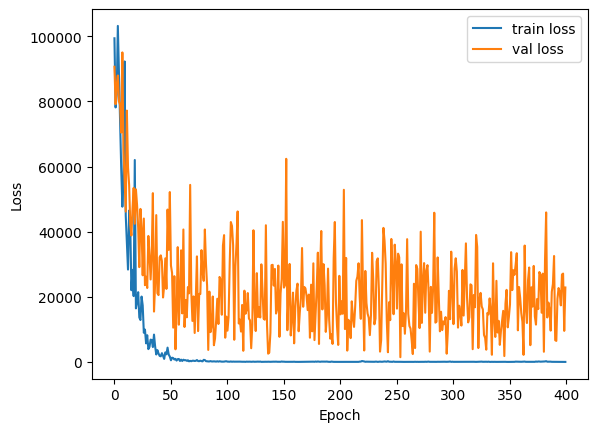

In [88]:
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.xscale('log')
plt.legend()
plt.show()

# Train Validation

In [137]:
#predict the whole batch of X_test and print mse
estimator.eval()
with torch.no_grad():
    outputs = estimator(torch.from_numpy(X_train).float())
    predicted = torch.round(outputs)
    mse = loss_fn(predicted, torch.from_numpy(y_train).unsqueeze(1).float())
    print (mse)

tensor(30.2559)


In [138]:
#create a dataframe with variables 'predicted' and 'y_test'
df = pd.DataFrame(columns=['predicted', 'y_train'])
df['predicted'] = predicted.squeeze().numpy()
df['y_train'] = y_train
df.head()

#order the values by y_test
df.sort_values(by=['y_train'], inplace=True)

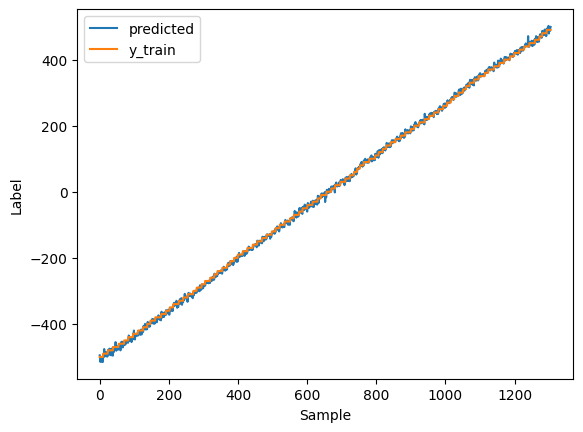

In [139]:
plt.plot(df['predicted'].values)
plt.plot(df['y_train'].values)
plt.xlabel('Sample')
plt.ylabel('Label')
plt.legend(['predicted', 'y_train'])
plt.show()

In [142]:
np.std(np.abs(predicted.squeeze().numpy() - y_train))

3.377134511207599

# Test Validation

In [144]:
#predict the whole batch of X_test and print mse
estimator.eval()
with torch.no_grad():
    outputs = estimator(torch.from_numpy(X_test).float())
    predicted = torch.round(outputs)
    mse = loss_fn(predicted, torch.from_numpy(y_test).unsqueeze(1).float())
    print (mse)

tensor(4887.2598)


In [148]:
#create a dataframe with variables 'predicted' and 'y_test'
df = pd.DataFrame(columns=['predicted', 'y_test'])
df['predicted'] = predicted.squeeze().numpy()
df['y_test'] = y_test
df.head()

#order the values by y_test
df.sort_values(by=['y_test'], inplace=True)

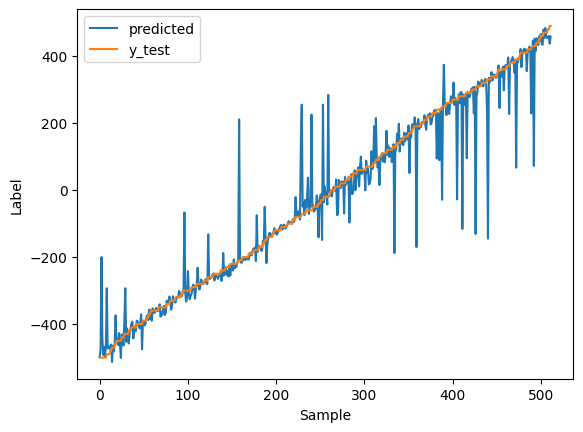

In [149]:
plt.plot(df['predicted'].values)
plt.plot(df['y_test'].values)
plt.xlabel('Sample')
plt.ylabel('Label')
plt.legend(['predicted', 'y_test'])
plt.show()

In [150]:
np.std(np.abs(predicted.squeeze().numpy() - y_test))

63.5861493641555

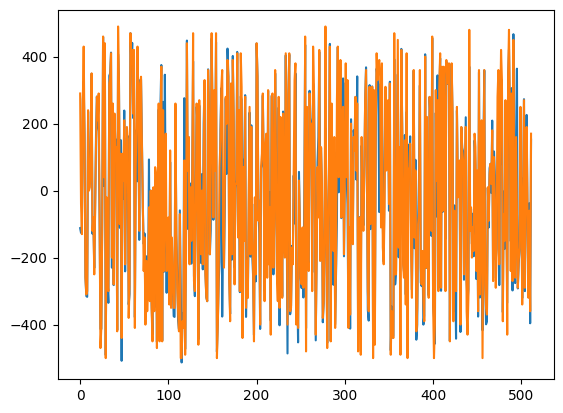

In [91]:
plt.plot(predicted)
plt.plot(y_test)

In [66]:
class Estimator(torch.nn.Module):
    def __init__(self):
        super(Estimator, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(3, 5, kernel_size=(8,8), stride=4),
                                  nn.LayerNorm((5, 63, 63)),
                                  nn.Mish(),
                                  nn.Conv2d(5, 8, kernel_size=(4,4), stride=2),
                                  nn.LayerNorm((8, 30, 30)),
                                  nn.Mish())

        self.linear = nn.Sequential(nn.LazyLinear(512),
                                 #   nn.LayerNorm(1024),
                                    nn.Mish(),
                                    nn.LazyLinear(256),
                                 #   nn.LayerNorm(512),
                                    nn.Mish(),
                                    nn.LazyLinear(10),
                                 #   nn.LayerNorm(10),
                                    nn.Mish(),
                                    nn.LazyLinear(1))
                                    #nn.Mish())
        self.flat = nn.Flatten(start_dim=1)

    def forward(self, x):
        x = self.conv(x)
        x = self.flat(x)
        x = self.linear(x)
        return x


In [9]:
#define data loaders
train_data = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_data = torch.utils.data.TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_data = torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=256, shuffle=True)

In [11]:
lr = 0.001
epochs = 400
estimator = Estimator()
loss_fn = nn.MSELoss()
train_loss = []
val_loss  = []

optimizer = torch.optim.Adam(estimator.parameters(), lr=lr)

#train using the validationn set
for epoch in range(epochs):
    for i, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = estimator(x.float()) # cast input tensor to float
        loss = loss_fn(y_pred, y.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
    train_loss.append(loss.item())
    for i, (x, y) in enumerate(val_loader):
        y_pred = estimator(x.float()) # cast input tensor to float
        loss = loss_fn(y_pred, y.unsqueeze(1).float())
    val_loss.append(loss.item())
    if (epoch % 1 == 0):
        print (f'Epoch: {epoch}, train loss: {train_loss[-1]}, val loss: {val_loss[-1]}')

Epoch: 0, train loss: 61291.390625, val loss: 79044.8671875
Epoch: 1, train loss: 90534.5625, val loss: 78188.0
Epoch: 2, train loss: 60141.73046875, val loss: 77279.3046875
Epoch: 3, train loss: 88326.8203125, val loss: 75871.7578125
Epoch: 4, train loss: 92647.15625, val loss: 73991.6953125
Epoch: 5, train loss: 85219.4765625, val loss: 70440.8671875
Epoch: 6, train loss: 64375.46484375, val loss: 74433.21875
Epoch: 7, train loss: 52238.28125, val loss: 73674.2109375
Epoch: 8, train loss: 47432.99609375, val loss: 64458.7890625
Epoch: 9, train loss: 42801.1953125, val loss: 65759.1640625
Epoch: 10, train loss: 61659.43359375, val loss: 59839.07421875
Epoch: 11, train loss: 27234.28515625, val loss: 56662.6640625
Epoch: 12, train loss: 31300.880859375, val loss: 54818.796875
Epoch: 13, train loss: 25401.796875, val loss: 52246.84765625
Epoch: 14, train loss: 67781.2890625, val loss: 50116.78515625
Epoch: 15, train loss: 41111.8515625, val loss: 50422.890625
Epoch: 16, train loss: 2669

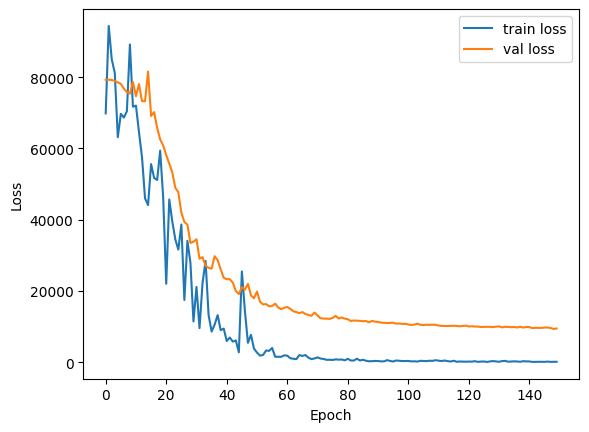

In [69]:
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.xscale('log')
plt.legend()
plt.show()

tensor(125.0077)


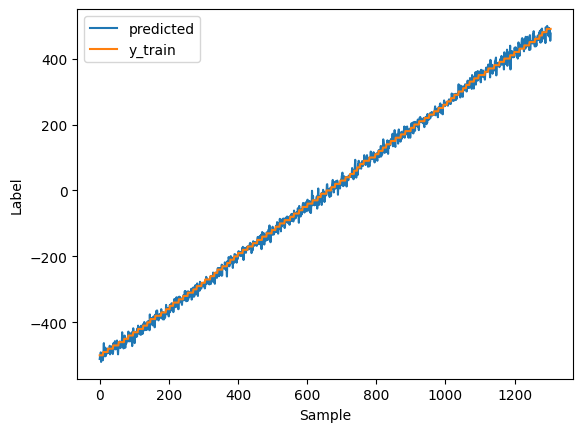

In [70]:
#predict the whole batch of X_test and print mse
estimator.eval()
with torch.no_grad():
    outputs = estimator(torch.from_numpy(X_train).float())
    predicted = torch.round(outputs)
    mse = loss_fn(predicted, torch.from_numpy(y_train).unsqueeze(1).float())
    print (mse)

#create a dataframe with variables 'predicted' and 'y_test'
df = pd.DataFrame(columns=['predicted', 'y_train'])
df['predicted'] = predicted.squeeze().numpy()
df['y_train'] = y_train
df.head()

#order the values by y_test
df.sort_values(by=['y_train'], inplace=True)

plt.plot(df['predicted'].values)
plt.plot(df['y_train'].values)
plt.xlabel('Sample')
plt.ylabel('Label')
plt.legend(['predicted', 'y_train'])
plt.show()



tensor(7078.9277)


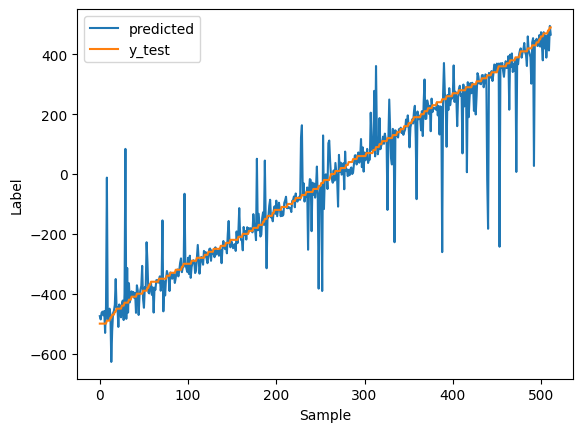

74.0334947148327


In [71]:
#predict the whole batch of X_test and print mse
estimator.eval()
with torch.no_grad():
    outputs = estimator(torch.from_numpy(X_test).float())
    predicted = torch.round(outputs)
    mse = loss_fn(predicted, torch.from_numpy(y_test).unsqueeze(1).float())
    print (mse)

#create a dataframe with variables 'predicted' and 'y_test'
df = pd.DataFrame(columns=['predicted', 'y_test'])
df['predicted'] = predicted.squeeze().numpy()
df['y_test'] = y_test
df.head()

#order the values by y_test
df.sort_values(by=['y_test'], inplace=True)

plt.plot(df['predicted'].values)
plt.plot(df['y_test'].values)
plt.xlabel('Sample')
plt.ylabel('Label')
plt.legend(['predicted', 'y_test'])
plt.show()

print (np.std(np.abs(predicted.squeeze().numpy() - y_test)))

tensor(6254.1387)


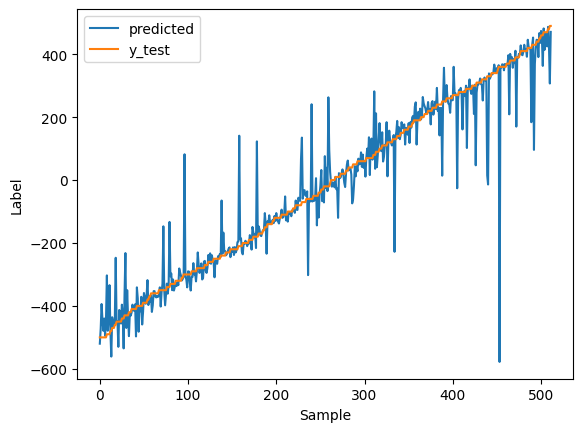

70.64683206074073


In [14]:
#predict the whole batch of X_test and print mse
estimator.eval()
with torch.no_grad():
    outputs = estimator(torch.from_numpy(X_test).float())
    predicted = torch.round(outputs)
    mse = loss_fn(predicted, torch.from_numpy(y_test).unsqueeze(1).float())
    print (mse)

#create a dataframe with variables 'predicted' and 'y_test'
df = pd.DataFrame(columns=['predicted', 'y_test'])
df['predicted'] = predicted.squeeze().numpy()
df['y_test'] = y_test
df.head()

#order the values by y_test
df.sort_values(by=['y_test'], inplace=True)

plt.plot(df['predicted'].values)
plt.plot(df['y_test'].values)
plt.xlabel('Sample')
plt.ylabel('Label')
plt.legend(['predicted', 'y_test'])
plt.show()

print (np.std(np.abs(predicted.squeeze().numpy() - y_test)))

In [15]:
!pwd

/home/luizf/Desktop/Luis/Images - stacks/stack3-crop


# K-Fold

In [87]:
X = data_t.copy()/255
y = pd.read_csv('data.csv')['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [88]:
#perform a k-fold cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(X)

mse = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index].squeeze(), y[test_index].squeeze()
    train_data = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    test_data = torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=256, shuffle=True)
    estimator = Estimator()
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(estimator.parameters(), lr=lr)
    for epoch in tqdm(range(epochs)):
        for i, (a, b) in enumerate(train_loader):
            optimizer.zero_grad()
            y_pred = estimator(a.float())
            loss = loss_fn(y_pred, b.unsqueeze(1).float())
            loss.backward()
            optimizer.step()


    estimator.eval()
    with torch.no_grad():
        outputs = estimator(torch.from_numpy(X_test).float())
        predicted = torch.round(outputs)
        mse.append(loss_fn(predicted, torch.from_numpy(y_test).unsqueeze(1).float()))

/home/luizf/miniconda3/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
100%|██████████| 150/150 [04:49<00:00,  1.93s/it]


In [90]:
np.mean(mse)

8376.643

In [8]:
class Estimator(torch.nn.Module):
    def __init__(self):
        super(Estimator, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(3, 4, kernel_size=(8,8), stride=4),
                                  nn.LayerNorm((4, 63, 63)),
                                  nn.Mish(),
                                  nn.Conv2d(4, 8, kernel_size=(4,4), stride=2),
                                  nn.LayerNorm((8, 30, 30)),
                                  nn.Mish())

        self.linear = nn.Sequential(nn.LazyLinear(512),
                                 #   nn.LayerNorm(1024),
                                    nn.Mish(),
                                    nn.LazyLinear(256),
                                 #   nn.LayerNorm(512),
                                    nn.Mish(),
                                    nn.LazyLinear(10),
                                 #   nn.LayerNorm(10),
                                    nn.Mish(),
                                    nn.LazyLinear(1))
                                    #nn.Mish())
        self.flat = nn.Flatten(start_dim=1)

    def forward(self, x):
        x = self.conv(x)
        x = self.flat(x)
        x = self.linear(x)
        return x


In [92]:
#perform a k-fold cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(X)

mse = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index].squeeze(), y[test_index].squeeze()
    train_data = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    test_data = torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=256, shuffle=True)
    estimator = Estimator()
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(estimator.parameters(), lr=lr)
    for epoch in tqdm(range(epochs)):
        for i, (a, b) in enumerate(train_loader):
            optimizer.zero_grad()
            y_pred = estimator(a.float())
            loss = loss_fn(y_pred, b.unsqueeze(1).float())
            loss.backward()
            optimizer.step()


    estimator.eval()
    with torch.no_grad():
        outputs = estimator(torch.from_numpy(X_test).float())
        predicted = torch.round(outputs)
        mse.append(loss_fn(predicted, torch.from_numpy(y_test).unsqueeze(1).float()))

print (np.mean(mse))

/home/luizf/miniconda3/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
100%|██████████| 150/150 [06:10<00:00,  2.47s/it]

7255.45


In [98]:
class Estimator(torch.nn.Module):
    def __init__(self):
        super(Estimator, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(3, 4, kernel_size=(8,8), stride=3),
                                  nn.LayerNorm((4, 83, 83)),
                                  nn.Mish(),
                                  nn.Conv2d(4, 8, kernel_size=(4,4), stride=2),
                                  nn.LayerNorm((8, 40, 40)),
                                  nn.Mish())

        self.linear = nn.Sequential(nn.LazyLinear(512),
                                 #   nn.LayerNorm(1024),
                                    nn.Mish(),
                                    nn.LazyLinear(256),
                                 #   nn.LayerNorm(512),
                                    nn.Mish(),
                                    nn.LazyLinear(10),
                                 #   nn.LayerNorm(10),
                                    nn.Mish(),
                                    nn.LazyLinear(1))
                                    #nn.Mish())
        self.flat = nn.Flatten(start_dim=1)

    def forward(self, x):
        x = self.conv(x)
        x = self.flat(x)
        x = self.linear(x)
        return x


In [99]:
#perform a k-fold cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(X)

mse = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index].squeeze(), y[test_index].squeeze()
    train_data = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    test_data = torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=256, shuffle=True)
    estimator = Estimator()
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(estimator.parameters(), lr=lr)
    for epoch in tqdm(range(epochs)):
        for i, (a, b) in enumerate(train_loader):
            optimizer.zero_grad()
            y_pred = estimator(a.float())
            loss = loss_fn(y_pred, b.unsqueeze(1).float())
            loss.backward()
            optimizer.step()


    estimator.eval()
    with torch.no_grad():
        outputs = estimator(torch.from_numpy(X_test).float())
        predicted = torch.round(outputs)
        mse.append(loss_fn(predicted, torch.from_numpy(y_test).unsqueeze(1).float()))

print (np.mean(mse))

100%|██████████| 150/150 [05:56<00:00,  2.38s/it]

7716.741
